In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

root_dir = "/content/drive/MyDrive/"
import os
os.chdir(root_dir + 'Project/Final_Dataset/')

Mounted at /content/drive/


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

csv_file = 'final_with_prehashtags.csv'
df = pd.read_csv(csv_file)

# load features from pickle
with open('merged_features.pkl', 'rb') as f:
    features = pickle.load(f)

In [ ]:
features['798'].shape

(1, 2560)

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for pre_hashtags,file_name in zip(df['Pre_Hashtags'], df['File Name']):
    image_id = file_name.split('.')[0]
    caption = pre_hashtags
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

#print("mapping:",mapping)

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

clean(mapping)

all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)


# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1


# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]#train test split5k

# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
import matplotlib.pyplot as plt
train_accuracy = []
train_loss = []
val_accuracy=[]
val_loss=[]
training_times = []


In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(2560,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 7)]                  0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 2560)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 7, 256)               3953664   ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2560)                 0         ['input_1[0][0]']             
                                                                                              

In [ ]:
import tensorflow as tf
total_params = sum(tf.keras.backend.count_params(w) for w in model.trainable_weights)
print("Total learnable parameters:", total_params)

Total learnable parameters: 9169492


In [ ]:
epochs = 100

batch_size = 32
steps = len(train) // batch_size
validation_steps = len(test) // batch_size

In [ ]:
import time

In [ ]:
# train the model

for i in range(epochs):
    train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    val_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    print("Epoch:", i + 1)
    start_time = time.time()
    history = model.fit(train_generator, epochs=1, steps_per_epoch=steps, validation_data=val_generator, validation_steps=validation_steps, verbose=1)
    end_time = time.time()
    epoch_time = end_time - start_time
    training_times.append(epoch_time)

    train_accuracy.append(history.history['accuracy'])
    train_loss.append(history.history['loss'])
    val_accuracy.append(history.history['val_accuracy'])
    val_loss.append(history.history['val_loss'])

Epoch: 1
235/235 [==============================] - 21s 59ms/step - loss: 7.4277 - accuracy: 0.1715 - val_loss: 6.6690 - val_accuracy: 0.1949
Epoch: 2
235/235 [==============================] - 8s 35ms/step - loss: 6.3918 - accuracy: 0.1938 - val_loss: 6.6833 - val_accuracy: 0.1921
Epoch: 3
235/235 [==============================] - 8s 35ms/step - loss: 6.2233 - accuracy: 0.1969 - val_loss: 6.8211 - val_accuracy: 0.2017
Epoch: 4
235/235 [==============================] - 8s 35ms/step - loss: 5.9604 - accuracy: 0.2044 - val_loss: 6.9426 - val_accuracy: 0.1997
Epoch: 5
235/235 [==============================] - 8s 36ms/step - loss: 5.8288 - accuracy: 0.2069 - val_loss: 7.3347 - val_accuracy: 0.2034
Epoch: 6
235/235 [==============================] - 8s 35ms/step - loss: 5.6775 - accuracy: 0.2091 - val_loss: 7.9234 - val_accuracy: 0.2048
Epoch: 7
235/235 [==============================] - 8s 35ms/step - loss: 5.5055 - accuracy: 0.2098 - val_loss: 7.8172 - val_accuracy: 0.2046
Epoch: 8
235

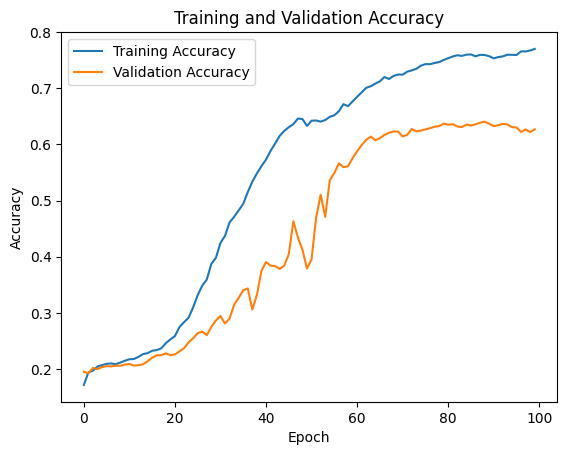

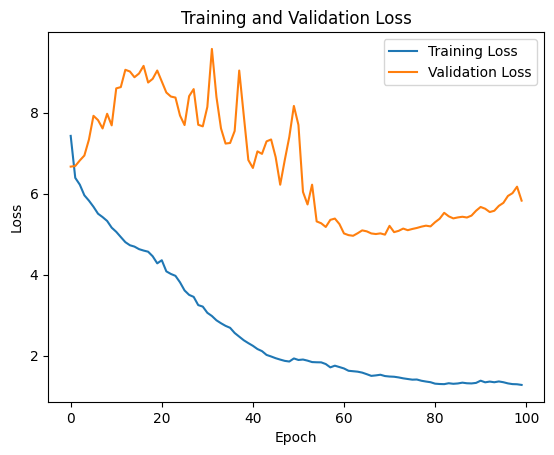

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)
test_steps = len(test) // batch_size

test_loss = model.evaluate(test_generator, steps=test_steps, verbose=1)
print("Test Loss:", test_loss)

105/105 [==============================] - 2s 16ms/step - loss: 5.8287 - accuracy: 0.6270
Test Loss: [5.828697681427002, 0.627041220664978]


In [ ]:
true_labels=[]

In [ ]:
for i in range(test_steps):
    X, y = next(test_generator)
    true_labels.extend(np.argmax(y, axis=1))

In [ ]:
predictions = model.predict(test_generator, steps=test_steps)

105/105 [==============================] - 3s 15ms/step


In [ ]:
predicted_hashtags = []

In [ ]:
for predict in predictions:
  yhat = np.argmax(predict)
  predicted_hashtags.append(yhat)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
precision = precision_score(true_labels, predicted_hashtags, average='weighted')
recall = recall_score(true_labels, predicted_hashtags, average='weighted')
f1 = f1_score(true_labels, predicted_hashtags, average='weighted')

In [ ]:
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.1672277620150068
Recall: 0.1719362684270611
F1 Score: 0.16755776483132678
